In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Carregando o vocabulário

In [2]:
import json

with open('./data/vocab.json', 'r') as infile:
    vocab = json.load(infile)

vocabSize = len(vocab['idx'])

print('Vocabulary size:', vocabSize)

Vocabulary size: 15244


### Configurações e Hiperparâmetros

In [3]:
import torch
import torch.nn as nn
from data import get_loaders
from train import train, test, check_input
import models 
from matplotlib import pyplot as plt

In [4]:
classes = [
  'negative',
  'somewhat negative',
  'neutral',
  'somewhat positive',
  'positive'
]

In [5]:
def plot_instance(instance_id):
    text = train_loader.dataset.texts[instance_id]
    label = train_loader.dataset.labels[instance_id]
    label_str = classes[train_loader.dataset.labels[instance_id]]
    print('\nExample:')
    print(text)
    print('Label:', label, '-', label_str)

In [6]:
data_path = './data/'
device_name = 'cuda'
batch_size = 1024
nb_epochs = 10
log_interval = 5
lr = 1e-2
lr_step = 3
num_layers = 1

In [7]:
device = torch.device(device_name)

train_loader, valid_loader = get_loaders(
    data_path=data_path, 
    batch_size=batch_size, 
    splits=['train', 'valid'],
)

nb_words = len(train_loader.dataset.vocab)

print(
    'Train size:', 
    len(train_loader.dataset.texts),
    len(train_loader.dataset.labels)
)
print(
    'Valid size:', 
    len(valid_loader.dataset.texts),
    len(valid_loader.dataset.labels)
)

plot_instance(0)
plot_instance(1015)
plot_instance(5136)
plot_instance(8974)


Train size: 99878 99878
Valid size: 24970 24970

Example:
a zombie
Label: 2 - neutral

Example:
the assumption
Label: 2 - neutral

Example:
hilarious and
Label: 4 - positive

Example:
good cast
Label: 3 - somewhat positive


In [8]:
def average_pooling(instances, lens):
    return torch.stack([
        text[:l].mean(0) for text, l in zip(instances, lens)
    ])


class TextLSTM(nn.Module):
    def __init__(self, num_embeddings=vocabSize, embedding_dim=100):
        '''
            num_embeddings: number of words in the dictionary
            embedding_dim: size of the word-embedding vector
        '''
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=num_embeddings, 
            embedding_dim=embedding_dim,
        )
        self.rnn = nn.LSTM(
            input_size=100, hidden_size=32, 
            batch_first=True, bidirectional=True,
            num_layers=num_layers
        )
        self.fc = nn.Linear(32*2, len(classes))
        
    def forward(self, x, lengths):
        # Transforma índices das palavras em vetores 
        x = self.embedding(x)
        # Processa vetores das palavras com uma rede recorrente
        hidden, output = self.rnn(x)
        # Faz a média das ativações de todas as iterações recorrentes
        vector = average_pooling(hidden, lengths)
        # Camada linear para classificacao
        x = self.fc(vector)
        return x


In [9]:
model = TextLSTM()
model = model.to(device)

dummy_pred = check_input(model, device)

Passed


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=lr_step)

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luciano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Treino e Validação


* * * Training * * *
Train Epoch:   1 [     0/ 99878 (0%)]	Loss: 1.611016
Train Epoch:   1 [  5120/ 99878 (5%)]	Loss: 1.264110
Train Epoch:   1 [ 10240/ 99878 (10%)]	Loss: 1.269159
Train Epoch:   1 [ 15360/ 99878 (15%)]	Loss: 1.201831
Train Epoch:   1 [ 20480/ 99878 (20%)]	Loss: 1.202241
Train Epoch:   1 [ 25600/ 99878 (26%)]	Loss: 1.164636
Train Epoch:   1 [ 30720/ 99878 (31%)]	Loss: 1.160964
Train Epoch:   1 [ 35840/ 99878 (36%)]	Loss: 1.118534
Train Epoch:   1 [ 40960/ 99878 (41%)]	Loss: 1.185104
Train Epoch:   1 [ 46080/ 99878 (46%)]	Loss: 1.046889
Train Epoch:   1 [ 51200/ 99878 (51%)]	Loss: 1.092203
Train Epoch:   1 [ 56320/ 99878 (56%)]	Loss: 1.083726
Train Epoch:   1 [ 61440/ 99878 (61%)]	Loss: 1.058730
Train Epoch:   1 [ 66560/ 99878 (66%)]	Loss: 1.089933
Train Epoch:   1 [ 71680/ 99878 (71%)]	Loss: 1.006585
Train Epoch:   1 [ 76800/ 99878 (77%)]	Loss: 1.000520
Train Epoch:   1 [ 81920/ 99878 (82%)]	Loss: 0.963241
Train Epoch:   1 [ 87040/ 99878 (87%)]	Loss: 0.963646
Train Ep

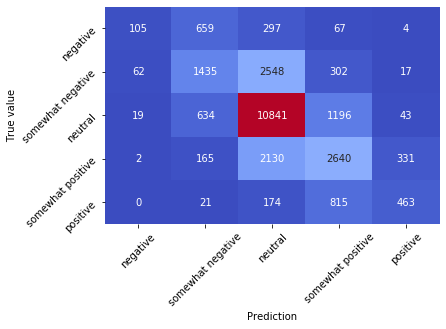


* * * Training * * *
Train Epoch:   2 [     0/ 99878 (0%)]	Loss: 0.847003
Train Epoch:   2 [  5120/ 99878 (5%)]	Loss: 0.861843
Train Epoch:   2 [ 10240/ 99878 (10%)]	Loss: 0.821270
Train Epoch:   2 [ 15360/ 99878 (15%)]	Loss: 0.827687
Train Epoch:   2 [ 20480/ 99878 (20%)]	Loss: 0.814516
Train Epoch:   2 [ 25600/ 99878 (26%)]	Loss: 0.786522
Train Epoch:   2 [ 30720/ 99878 (31%)]	Loss: 0.817710
Train Epoch:   2 [ 35840/ 99878 (36%)]	Loss: 0.837252
Train Epoch:   2 [ 40960/ 99878 (41%)]	Loss: 0.848028
Train Epoch:   2 [ 46080/ 99878 (46%)]	Loss: 0.801201
Train Epoch:   2 [ 51200/ 99878 (51%)]	Loss: 0.811385
Train Epoch:   2 [ 56320/ 99878 (56%)]	Loss: 0.836147
Train Epoch:   2 [ 61440/ 99878 (61%)]	Loss: 0.830117
Train Epoch:   2 [ 66560/ 99878 (66%)]	Loss: 0.824496
Train Epoch:   2 [ 71680/ 99878 (71%)]	Loss: 0.814000
Train Epoch:   2 [ 76800/ 99878 (77%)]	Loss: 0.813007
Train Epoch:   2 [ 81920/ 99878 (82%)]	Loss: 0.856950
Train Epoch:   2 [ 87040/ 99878 (87%)]	Loss: 0.806477
Train Ep

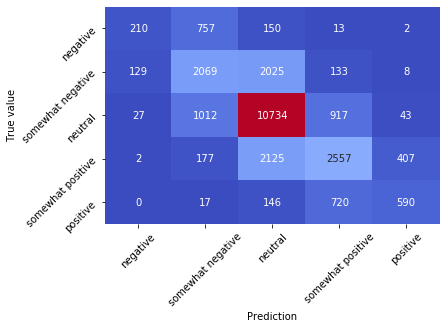


* * * Training * * *
Train Epoch:   3 [     0/ 99878 (0%)]	Loss: 0.734375
Train Epoch:   3 [  5120/ 99878 (5%)]	Loss: 0.700948
Train Epoch:   3 [ 10240/ 99878 (10%)]	Loss: 0.707809
Train Epoch:   3 [ 15360/ 99878 (15%)]	Loss: 0.690505
Train Epoch:   3 [ 20480/ 99878 (20%)]	Loss: 0.710510
Train Epoch:   3 [ 25600/ 99878 (26%)]	Loss: 0.708584
Train Epoch:   3 [ 30720/ 99878 (31%)]	Loss: 0.731997
Train Epoch:   3 [ 35840/ 99878 (36%)]	Loss: 0.715257
Train Epoch:   3 [ 40960/ 99878 (41%)]	Loss: 0.705262
Train Epoch:   3 [ 46080/ 99878 (46%)]	Loss: 0.702318
Train Epoch:   3 [ 51200/ 99878 (51%)]	Loss: 0.749564
Train Epoch:   3 [ 56320/ 99878 (56%)]	Loss: 0.707807
Train Epoch:   3 [ 61440/ 99878 (61%)]	Loss: 0.693773
Train Epoch:   3 [ 66560/ 99878 (66%)]	Loss: 0.713067
Train Epoch:   3 [ 71680/ 99878 (71%)]	Loss: 0.746056
Train Epoch:   3 [ 76800/ 99878 (77%)]	Loss: 0.770212
Train Epoch:   3 [ 81920/ 99878 (82%)]	Loss: 0.733829
Train Epoch:   3 [ 87040/ 99878 (87%)]	Loss: 0.701834
Train Ep

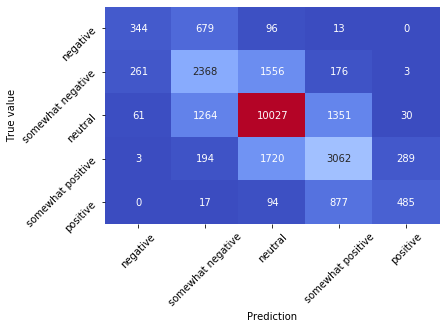


* * * Training * * *
Train Epoch:   4 [     0/ 99878 (0%)]	Loss: 0.636707
Train Epoch:   4 [  5120/ 99878 (5%)]	Loss: 0.656146
Train Epoch:   4 [ 10240/ 99878 (10%)]	Loss: 0.618581
Train Epoch:   4 [ 15360/ 99878 (15%)]	Loss: 0.594236
Train Epoch:   4 [ 20480/ 99878 (20%)]	Loss: 0.615640
Train Epoch:   4 [ 25600/ 99878 (26%)]	Loss: 0.627872
Train Epoch:   4 [ 30720/ 99878 (31%)]	Loss: 0.629827
Train Epoch:   4 [ 35840/ 99878 (36%)]	Loss: 0.599511
Train Epoch:   4 [ 40960/ 99878 (41%)]	Loss: 0.594005
Train Epoch:   4 [ 46080/ 99878 (46%)]	Loss: 0.587291
Train Epoch:   4 [ 51200/ 99878 (51%)]	Loss: 0.603947
Train Epoch:   4 [ 56320/ 99878 (56%)]	Loss: 0.620579
Train Epoch:   4 [ 61440/ 99878 (61%)]	Loss: 0.607907
Train Epoch:   4 [ 66560/ 99878 (66%)]	Loss: 0.635800
Train Epoch:   4 [ 71680/ 99878 (71%)]	Loss: 0.612222
Train Epoch:   4 [ 76800/ 99878 (77%)]	Loss: 0.630513
Train Epoch:   4 [ 81920/ 99878 (82%)]	Loss: 0.620722
Train Epoch:   4 [ 87040/ 99878 (87%)]	Loss: 0.610925
Train Ep

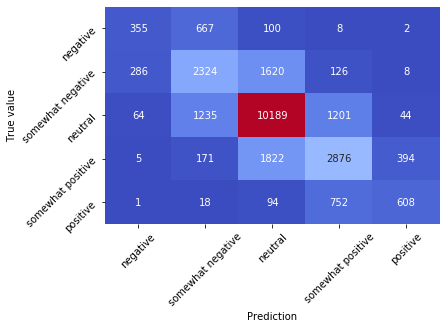


* * * Training * * *
Train Epoch:   5 [     0/ 99878 (0%)]	Loss: 0.626284
Train Epoch:   5 [  5120/ 99878 (5%)]	Loss: 0.595516
Train Epoch:   5 [ 10240/ 99878 (10%)]	Loss: 0.567576
Train Epoch:   5 [ 15360/ 99878 (15%)]	Loss: 0.601600
Train Epoch:   5 [ 20480/ 99878 (20%)]	Loss: 0.583252
Train Epoch:   5 [ 25600/ 99878 (26%)]	Loss: 0.595228
Train Epoch:   5 [ 30720/ 99878 (31%)]	Loss: 0.582475
Train Epoch:   5 [ 35840/ 99878 (36%)]	Loss: 0.566460
Train Epoch:   5 [ 40960/ 99878 (41%)]	Loss: 0.629910
Train Epoch:   5 [ 46080/ 99878 (46%)]	Loss: 0.599823
Train Epoch:   5 [ 51200/ 99878 (51%)]	Loss: 0.604086
Train Epoch:   5 [ 56320/ 99878 (56%)]	Loss: 0.605476
Train Epoch:   5 [ 61440/ 99878 (61%)]	Loss: 0.593925
Train Epoch:   5 [ 66560/ 99878 (66%)]	Loss: 0.614966
Train Epoch:   5 [ 71680/ 99878 (71%)]	Loss: 0.620007
Train Epoch:   5 [ 76800/ 99878 (77%)]	Loss: 0.613012
Train Epoch:   5 [ 81920/ 99878 (82%)]	Loss: 0.595951
Train Epoch:   5 [ 87040/ 99878 (87%)]	Loss: 0.595521
Train Ep

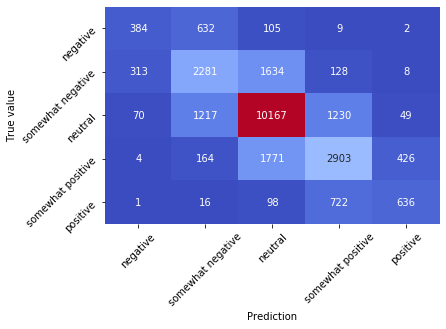


* * * Training * * *
Train Epoch:   6 [     0/ 99878 (0%)]	Loss: 0.570146
Train Epoch:   6 [  5120/ 99878 (5%)]	Loss: 0.608823
Train Epoch:   6 [ 10240/ 99878 (10%)]	Loss: 0.590284
Train Epoch:   6 [ 15360/ 99878 (15%)]	Loss: 0.556206
Train Epoch:   6 [ 20480/ 99878 (20%)]	Loss: 0.557860
Train Epoch:   6 [ 25600/ 99878 (26%)]	Loss: 0.575943
Train Epoch:   6 [ 30720/ 99878 (31%)]	Loss: 0.607606
Train Epoch:   6 [ 35840/ 99878 (36%)]	Loss: 0.617200
Train Epoch:   6 [ 40960/ 99878 (41%)]	Loss: 0.568014
Train Epoch:   6 [ 46080/ 99878 (46%)]	Loss: 0.623979
Train Epoch:   6 [ 51200/ 99878 (51%)]	Loss: 0.602798
Train Epoch:   6 [ 56320/ 99878 (56%)]	Loss: 0.564843
Train Epoch:   6 [ 61440/ 99878 (61%)]	Loss: 0.616409
Train Epoch:   6 [ 66560/ 99878 (66%)]	Loss: 0.570200
Train Epoch:   6 [ 71680/ 99878 (71%)]	Loss: 0.571063
Train Epoch:   6 [ 76800/ 99878 (77%)]	Loss: 0.582265
Train Epoch:   6 [ 81920/ 99878 (82%)]	Loss: 0.532681
Train Epoch:   6 [ 87040/ 99878 (87%)]	Loss: 0.547266
Train Ep

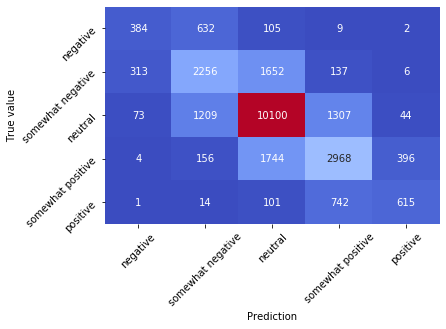


* * * Training * * *
Train Epoch:   7 [     0/ 99878 (0%)]	Loss: 0.546037
Train Epoch:   7 [  5120/ 99878 (5%)]	Loss: 0.567717
Train Epoch:   7 [ 10240/ 99878 (10%)]	Loss: 0.558837
Train Epoch:   7 [ 15360/ 99878 (15%)]	Loss: 0.530593
Train Epoch:   7 [ 20480/ 99878 (20%)]	Loss: 0.551428
Train Epoch:   7 [ 25600/ 99878 (26%)]	Loss: 0.559677
Train Epoch:   7 [ 30720/ 99878 (31%)]	Loss: 0.526862
Train Epoch:   7 [ 35840/ 99878 (36%)]	Loss: 0.595442
Train Epoch:   7 [ 40960/ 99878 (41%)]	Loss: 0.590067
Train Epoch:   7 [ 46080/ 99878 (46%)]	Loss: 0.582831
Train Epoch:   7 [ 51200/ 99878 (51%)]	Loss: 0.568294
Train Epoch:   7 [ 56320/ 99878 (56%)]	Loss: 0.548090
Train Epoch:   7 [ 61440/ 99878 (61%)]	Loss: 0.533935
Train Epoch:   7 [ 66560/ 99878 (66%)]	Loss: 0.566849
Train Epoch:   7 [ 71680/ 99878 (71%)]	Loss: 0.565271
Train Epoch:   7 [ 76800/ 99878 (77%)]	Loss: 0.567906
Train Epoch:   7 [ 81920/ 99878 (82%)]	Loss: 0.561429
Train Epoch:   7 [ 87040/ 99878 (87%)]	Loss: 0.581260
Train Ep

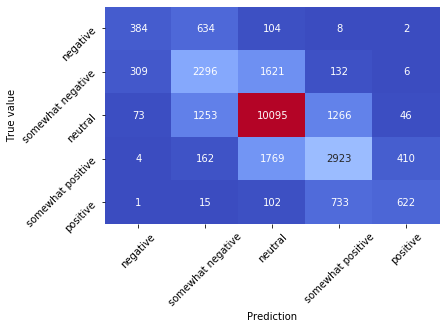


* * * Training * * *
Train Epoch:   8 [     0/ 99878 (0%)]	Loss: 0.567591
Train Epoch:   8 [  5120/ 99878 (5%)]	Loss: 0.580171
Train Epoch:   8 [ 10240/ 99878 (10%)]	Loss: 0.532588
Train Epoch:   8 [ 15360/ 99878 (15%)]	Loss: 0.538035
Train Epoch:   8 [ 20480/ 99878 (20%)]	Loss: 0.562769
Train Epoch:   8 [ 25600/ 99878 (26%)]	Loss: 0.544596
Train Epoch:   8 [ 30720/ 99878 (31%)]	Loss: 0.564261
Train Epoch:   8 [ 35840/ 99878 (36%)]	Loss: 0.560181
Train Epoch:   8 [ 40960/ 99878 (41%)]	Loss: 0.591029
Train Epoch:   8 [ 46080/ 99878 (46%)]	Loss: 0.574951
Train Epoch:   8 [ 51200/ 99878 (51%)]	Loss: 0.547780
Train Epoch:   8 [ 56320/ 99878 (56%)]	Loss: 0.568535
Train Epoch:   8 [ 61440/ 99878 (61%)]	Loss: 0.560127
Train Epoch:   8 [ 66560/ 99878 (66%)]	Loss: 0.542505
Train Epoch:   8 [ 71680/ 99878 (71%)]	Loss: 0.584305
Train Epoch:   8 [ 76800/ 99878 (77%)]	Loss: 0.535363
Train Epoch:   8 [ 81920/ 99878 (82%)]	Loss: 0.543644
Train Epoch:   8 [ 87040/ 99878 (87%)]	Loss: 0.566021
Train Ep

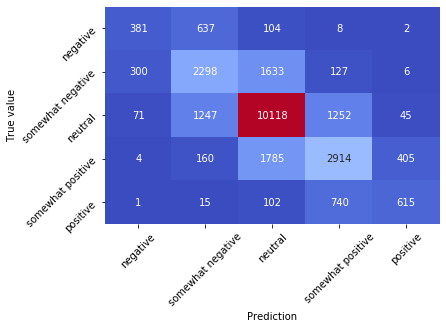


* * * Training * * *
Train Epoch:   9 [     0/ 99878 (0%)]	Loss: 0.540847
Train Epoch:   9 [  5120/ 99878 (5%)]	Loss: 0.556702
Train Epoch:   9 [ 10240/ 99878 (10%)]	Loss: 0.563228
Train Epoch:   9 [ 15360/ 99878 (15%)]	Loss: 0.583574
Train Epoch:   9 [ 20480/ 99878 (20%)]	Loss: 0.546862
Train Epoch:   9 [ 25600/ 99878 (26%)]	Loss: 0.589211
Train Epoch:   9 [ 30720/ 99878 (31%)]	Loss: 0.586245
Train Epoch:   9 [ 35840/ 99878 (36%)]	Loss: 0.527184
Train Epoch:   9 [ 40960/ 99878 (41%)]	Loss: 0.500271
Train Epoch:   9 [ 46080/ 99878 (46%)]	Loss: 0.569855
Train Epoch:   9 [ 51200/ 99878 (51%)]	Loss: 0.559257
Train Epoch:   9 [ 56320/ 99878 (56%)]	Loss: 0.566044
Train Epoch:   9 [ 61440/ 99878 (61%)]	Loss: 0.583676
Train Epoch:   9 [ 66560/ 99878 (66%)]	Loss: 0.564402
Train Epoch:   9 [ 71680/ 99878 (71%)]	Loss: 0.582118
Train Epoch:   9 [ 76800/ 99878 (77%)]	Loss: 0.535082
Train Epoch:   9 [ 81920/ 99878 (82%)]	Loss: 0.575397
Train Epoch:   9 [ 87040/ 99878 (87%)]	Loss: 0.551556
Train Ep

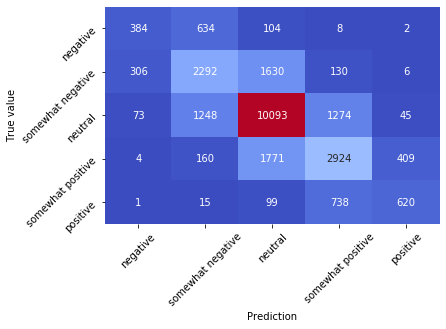


* * * Training * * *
Train Epoch:  10 [     0/ 99878 (0%)]	Loss: 0.555293
Train Epoch:  10 [  5120/ 99878 (5%)]	Loss: 0.547422
Train Epoch:  10 [ 10240/ 99878 (10%)]	Loss: 0.542947
Train Epoch:  10 [ 15360/ 99878 (15%)]	Loss: 0.591362
Train Epoch:  10 [ 20480/ 99878 (20%)]	Loss: 0.551655
Train Epoch:  10 [ 25600/ 99878 (26%)]	Loss: 0.535827
Train Epoch:  10 [ 30720/ 99878 (31%)]	Loss: 0.612512
Train Epoch:  10 [ 35840/ 99878 (36%)]	Loss: 0.555406
Train Epoch:  10 [ 40960/ 99878 (41%)]	Loss: 0.569764
Train Epoch:  10 [ 46080/ 99878 (46%)]	Loss: 0.554123
Train Epoch:  10 [ 51200/ 99878 (51%)]	Loss: 0.562319
Train Epoch:  10 [ 56320/ 99878 (56%)]	Loss: 0.576332
Train Epoch:  10 [ 61440/ 99878 (61%)]	Loss: 0.575294
Train Epoch:  10 [ 66560/ 99878 (66%)]	Loss: 0.571114
Train Epoch:  10 [ 71680/ 99878 (71%)]	Loss: 0.568586
Train Epoch:  10 [ 76800/ 99878 (77%)]	Loss: 0.560295
Train Epoch:  10 [ 81920/ 99878 (82%)]	Loss: 0.570974
Train Epoch:  10 [ 87040/ 99878 (87%)]	Loss: 0.563109
Train Ep

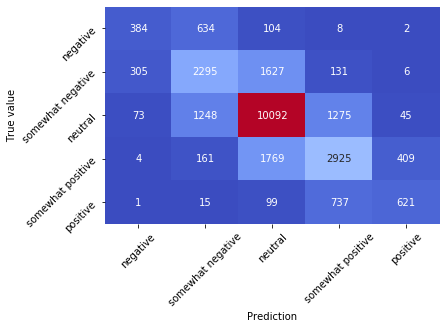

In [12]:
history = train(
    model=model, train_loader=train_loader, test_loader=valid_loader, classes=classes,
    device=device, optimizer=optimizer, lr_scheduler=lr_scheduler,
    nb_epochs=nb_epochs, log_interval=log_interval
)

### Resultados do treino

In [13]:
print('Max val acc: {:.2f}%'.format(max(history['val_acc'])))

Max val acc: 65.56%


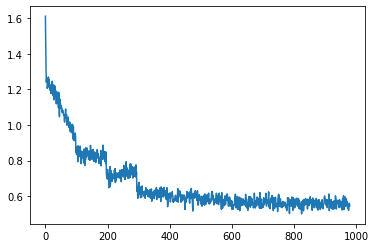

In [14]:
plt.plot(history['train_loss'])
plt.show()

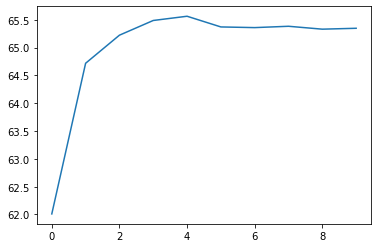

In [15]:
plt.plot(history['val_acc'])
plt.show()